In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-04 14:23:37 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-04 14:23:38 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-04 14:23:38 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-04 14:23:41 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-04 14:23:41 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-04 14:23:41 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-04 14:23:41 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-04 14:23:42 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-04 14:23:42 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-04 14:23:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-04 14:23:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-04 14:23:42 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-04 14:24:30 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-04 14:24:30 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-04 14:24:30 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

select_task.filter_single_token(tokenizer=mt.tokenizer, prefix=" ")

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(11), vehicle(8), furniture(8), animal(13), music instrument(3), clothing(11), electronics(11), sport equipment(5), kitchen appliance(4), vegetable(5), building(14), office supply(8), bathroom item(7), flower(6), tree(10), jewelry(7)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Banana -> Apple (2): ['Lion', 'Tomato', 'Apple', 'Violet', 'Warehouse', 'Notebook']
Options: Lion, Tomato, Apple, Violet, Warehouse, Notebook.
Which among these objects mentioned above is a fruit?
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Lion, Tomato, Apple, Violet, Warehouse, Notebook.
Which among these objects mentioned above is a fruit?
Answer:" >> Apple


(True,
 [PredictedToken(token=' Apple', prob=0.5625, logit=20.625, token_id=8325, metadata=None),
  PredictedToken(token=' Among', prob=0.142578125, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' Tomato', prob=0.08642578125, logit=18.75, token_id=94091, metadata=None),
  PredictedToken(token=' The', prob=0.08642578125, logit=18.75, token_id=578, metadata=None),
  PredictedToken(token=' An', prob=0.0169677734375, logit=17.125, token_id=1556, metadata=None)],
 OrderedDict([(8325,
               (1,
                PredictedToken(token=' Apple', prob=0.5625, logit=20.625, token_id=8325, metadata=None))),
              (94091,
               (4,
                PredictedToken(token=' Tomato', prob=0.08642578125, logit=18.75, token_id=94091, metadata=None))),
              (33199,
               (17,
                PredictedToken(token=' Lion', prob=0.002960205078125, logit=15.375, token_id=33199, metadata=None))),
              (74574,
               (141,
         

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Apple and Tomato are fruits.
Explanation: Apple and Tomato are the only fruits among the given options." >> Apple


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [11]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]
# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

10


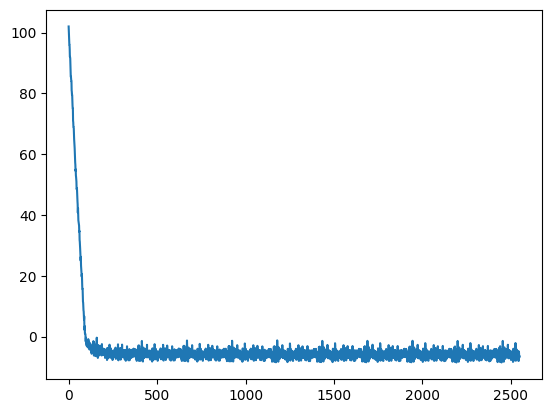

In [13]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    f"{select_task.task_name}",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

80


(True, True)

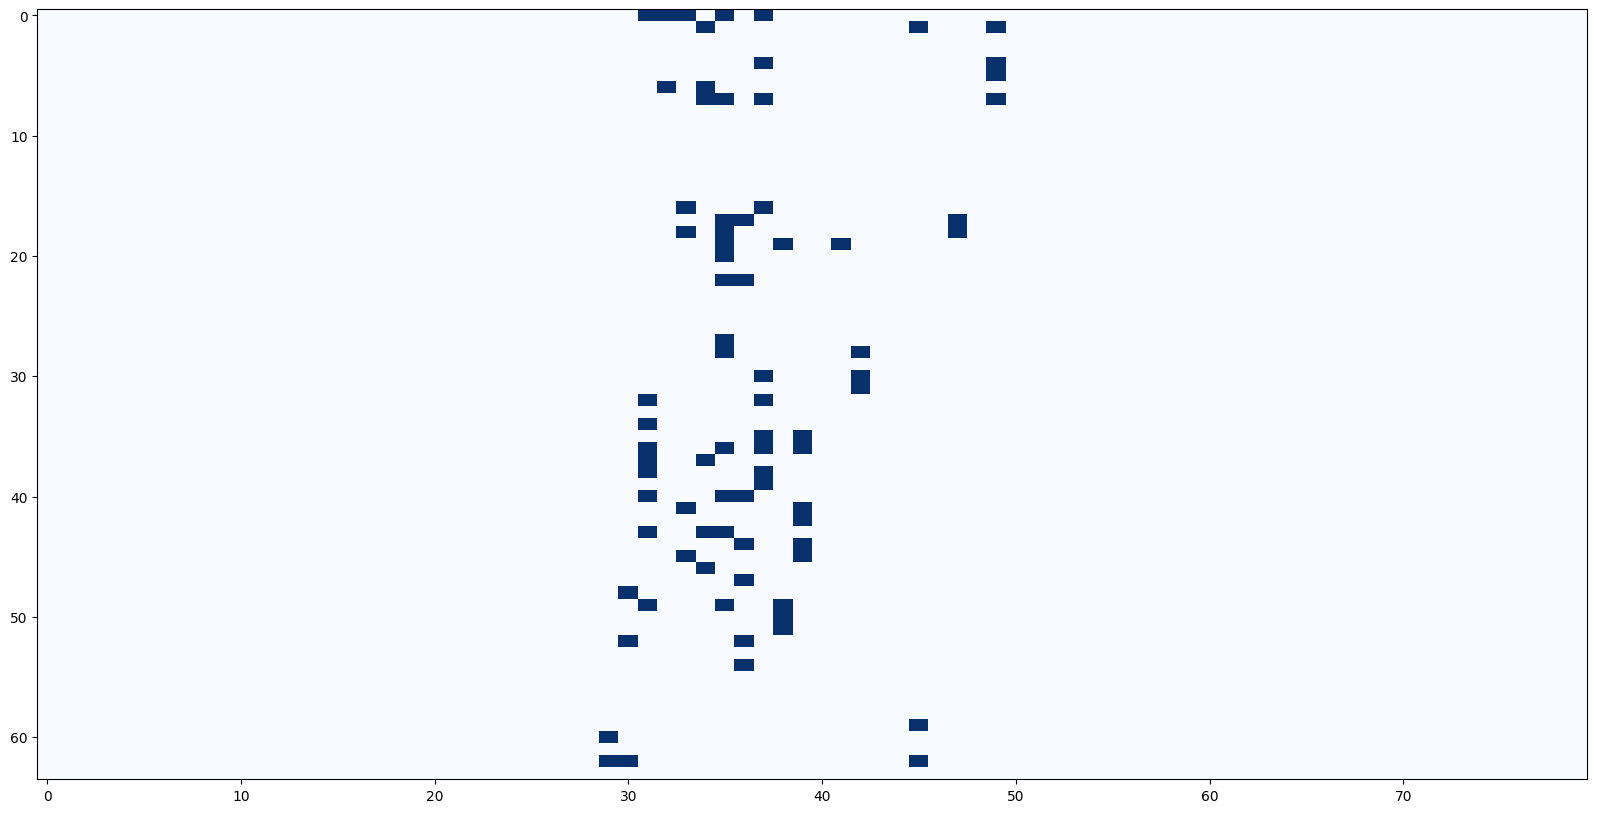

In [14]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [15]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

2025-09-04 14:29:58 src.selection.functional DEBUG    Predictions: ['" Apple"[8325] (p=0.562, logit=20.625)', '" Among"[22395] (p=0.143, logit=19.250)', '" Tomato"[94091] (p=0.086, logit=18.750)', '" The"[578] (p=0.086, logit=18.750)', '" An"[1556] (p=0.017, logit=17.125)']
2025-09-04 14:29:58 src.selection.functional INFO     Combined attention matrix for all heads


In [16]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    option_style="numbered",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=n_distractors - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template=task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        **kwargs,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [17]:
type(select_task)

src.selection.data.SelectOneTask

In [18]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    n_distractors=5,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

clean_sample.metadata

2025-09-04 14:30:20 __main__ INFO     Patch category: fruit, subject: Grape, object: Strawberry
2025-09-04 14:30:20 __main__ INFO     Clean category: vehicle, subject: Truck, object: Motorcycle
2025-09-04 14:30:20 __main__ INFO     patch_must_have_options=['Strawberry', 'Van']
2025-09-04 14:30:20 __main__ INFO     clean_must_have_options=['Motorcycle', 'Peach']
2025-09-04 14:30:20 __main__ INFO     clean_type_obj='Van'
2025-09-04 14:30:20 __main__ INFO     patch_type_obj='Peach'
2025-09-04 14:30:20 __main__ INFO     patch_obj_idx=0 | ['Strawberry', 'Van', 'Notebook', 'Jasmine', 'Blender', 'Tie']
2025-09-04 14:30:20 __main__ INFO     clean_obj_idx=2 | ['Iris', 'Tomato', 'Motorcycle', 'School', 'Willow', 'Peach']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-04 14:30:20 __main__ INFO     Options: Strawberry, Van, Notebook, Jasmine, Blender, Tie.
Which among these objects mentioned above is a fruit?
Answer:
2025-09-04 14:30:20 __main__ INFO     Grape | fruit -> Strawberry | pred=['" Strawberry"[89077] (p=0.707, logit=21.125)', '" The"[578] (p=0.139, logit=19.500)', '" Among"[22395] (p=0.065, logit=18.750)', '" A"[362] (p=0.024, logit=17.750)', '" strawberry"[73700] (p=0.011, logit=17.000)']
2025-09-04 14:30:20 __main__ INFO     Options: Iris, Tomato, Motorcycle, School, Willow, Peach.
Which among these objects mentioned above is a vehicle?
Answer:
2025-09-04 14:30:20 __main__ INFO     Truck | vehicle -> Motorcycle | pred=['" Motorcycle"[70762] (p=0.949, logit=23.500)', '" The"[578] (p=0.017, logit=19.500)', '" Among"[22395] (p=0.012, logit=19.125)', '" A"[362] (p=0.012, logit=19.125)', '" Motor"[18079] (p=0.001, logit=17.000)']
2025-09-04 14:30:20 __main__ INFO     Options: Iris,

{'track_category': 'fruit',
 'track_type_obj': 'Peach',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 64695,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  72392,     11,   6150,     11,  64695,     11,
            82452,     11,  45332,     11,  86460,    627,  23956,   4315,   1521,
             6302,   9932,   3485,    374,    264,   7458,   5380,  16533,     25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]], device='cuda:0')}}

In [31]:
from src.functional import generate_with_patch
mt.reset_forward()
mt.set_attn_implementation("eager")

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj
patch_sample.options = ["Cherry", "Knife", "Pen", "Ambulance"]
clean_sample.options = ["Binder", "Peach", "Watch", "Scooter", "Phone"]
clean_sample.metadata = {
    "track_category": "fruit",
    "track_type_obj": "Peach",
    "track_type_obj_idx": 1,
    "track_type_obj_token_id": get_first_token_id(tokenizer=mt.tokenizer, name="Peach", prefix=" ")
}
clean_sample.obj_idx = 3
clean_sample.obj = "Scooter"
clean_sample.ans_token_id = get_first_token_id(tokenizer=mt.tokenizer, name="Scooter", prefix=" ")

clean_sample.prompt_template = "<_options_>\nFind the <_category_> in the list.\nAnswer:"
patch_sample.prompt_template = "<_options_>\nFind the <_category_> in the list.\nAnswer:"

for sample in [patch_sample, clean_sample]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        # heads=HEADS,
        heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

Options: Cherry, Knife, Pen, Ambulance.
Find the fruit in the list.
Answer: >> Apple
2025-09-04 14:42:00 src.selection.functional DEBUG    Predictions: ['" Cherry"[45805] (p=0.750, logit=22.125)', '" The"[578] (p=0.215, logit=20.875)', '" CH"[6969] (p=0.007, logit=17.375)', '" A"[362] (p=0.005, logit=17.125)', '" There"[2684] (p=0.005, logit=17.125)']
2025-09-04 14:42:00 src.selection.functional INFO     Combined attention matrix for all heads


Options: Binder, Peach, Watch, Scooter, Phone.
Find the vehicle in the list.
Answer: >> Scooter
2025-09-04 14:42:00 src.selection.functional DEBUG    Predictions: ['" Sco"[50159] (p=0.922, logit=22.250)', '" The"[578] (p=0.031, logit=18.875)', '" A"[362] (p=0.017, logit=18.250)', '" There"[2684] (p=0.008, logit=17.500)', '" scooter"[76140] (p=0.004, logit=16.875)']
2025-09-04 14:42:00 src.selection.functional INFO     Combined attention matrix for all heads


In [32]:
from src.selection.functional import cache_q_projections
from src.functional import PatchSpec

mt.reset_forward()
mt.set_attn_implementation("eager")
#####################################################
query_indices = {-3: -3, -2: -2, -1: -1}
#####################################################

clean_tokenized = prepare_input(
    prompts=clean_sample.prompt(), 
    tokenizer=mt.tokenizer,
    return_offsets_mapping=True
)
clean_offsets = clean_tokenized.pop("offset_mapping")[0]

patch_tokenized = prepare_input(
    prompts=patch_sample.prompt(), 
    tokenizer=mt.tokenizer,
    return_offsets_mapping=True
)
patch_offsets = patch_tokenized.pop("offset_mapping")[0]

query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in HEADS
    # for layer_idx, head_idx in [(35, 19)]
    for patch_query_idx in query_indices.keys()
]

cached_q_states, patch_output = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)

q_proj_patches = []
for (layer_idx, head_idx, patch_query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_indices[patch_query_idx],
            ),
            patch=q_proj,
        )
    )

attn_pattern = verify_head_patterns(
    prompt=clean_sample.prompt(),
    options=clean_sample.options,
    pivot=clean_sample.subj,
    mt=mt,
    # heads=HEADS,
    heads=[(35, 19)],
    query_index=-1,
    query_patches=q_proj_patches
)

2025-09-04 14:42:04 src.selection.functional DEBUG    Predictions: ['" Binder"[91263] (p=0.703, logit=21.125)', '" Peach"[64695] (p=0.178, logit=19.750)', '" The"[578] (p=0.065, logit=18.750)', '" There"[2684] (p=0.011, logit=17.000)', '" A"[362] (p=0.009, logit=16.750)']
2025-09-04 14:42:04 src.selection.functional INFO     Combined attention matrix for all heads


In [33]:
# clean_sample.obj, clean_sample.metadata['track_type_obj']
from src.tokens import find_token_range

# random_target = random.choice(
#     list(
#         set(clean_sample.options)
#         - {clean_sample.obj, clean_sample.metadata["track_type_obj"]}
#     )
# )
random_target = "Phone"
logger.debug(f"Random target: {random_target}")

patch_type_obj_token_idx = (
    find_token_range(
        string=clean_sample.prompt(),
        substring=clean_sample.metadata["track_type_obj"],
        # substring=clean_sample.obj,
        offset_mapping=clean_offsets,
    )[1]
    - 1
)
logger.debug(
    f'{patch_type_obj_token_idx=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][patch_type_obj_token_idx])}"'
)

target_obj_token_idx = (
    find_token_range(
        string=clean_sample.prompt(),
        substring=random_target,
        offset_mapping=clean_offsets,
    )[1]
    - 1
)
logger.debug(
    f'{target_obj_token_idx=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][target_obj_token_idx])}"'
)

2025-09-04 14:42:05 __main__ DEBUG    Random target: Phone
2025-09-04 14:42:05 __main__ DEBUG    patch_type_obj_token_idx=5 | " Peach"
2025-09-04 14:42:05 __main__ DEBUG    target_obj_token_idx=12 | " Phone"


In [34]:
# import nnsight
# with mt.trace("hello") as tracer:
#     hs = mt.model.layers[-1].output[0]
#     tracer.log(hs[0,0,0])
#     out =  mt.lm_head.output.save()

# print(out)

In [35]:
from src.selection.functional import cache_q_projections

key_indices = {
    patch_type_obj_token_idx: target_obj_token_idx,
    target_obj_token_idx: patch_type_obj_token_idx,
}

key_locations = [
    (layer_idx, head_idx, patch_key_idx)
    for layer_idx, head_idx in HEADS
    # for layer_idx, head_idx in [(35, 19)]
    for patch_key_idx in key_indices.keys()
]

cached_k_states = cache_q_projections(
    mt=mt,
    input=clean_tokenized, #! should always be clean_tokenized
    query_locations=key_locations,
    return_output=False,
    projection_signature=".k_proj",
)

k_proj_patches = []
for (layer_idx, head_idx, patch_key_idx), k_proj in cached_k_states.items():
    k_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".k_proj",
                head_idx,
                key_indices[patch_key_idx],
            ),
            patch=k_proj,
        )
    )

In [36]:
# import math
# from src.functional import get_module_nnsight, repeat_kv
# from src.attention import visualize_attn_matrix
# from src.hooking.llama_attention import apply_rotary_pos_emb

# layer_idx, head_idx = (35, 19)
# with mt.trace(clean_tokenized) as tracer:
#     q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
#     q_proj_module = get_module_nnsight(mt, q_proj_name)
#     clean_q_proj = q_proj_module.output.save()
#     # tracer.log(patch_q_proj.shape)

#     k_proj_name = mt.attn_module_name_format.format(layer_idx) + ".k_proj"
#     k_proj_module = get_module_nnsight(mt, k_proj_name)
#     clean_k_proj = k_proj_module.output.save()
#     # tracer.log(patch_k_proj.shape)

# query = clean_q_proj
# key = clean_k_proj
# print(f"{query.shape=}, {key.shape=}")

# batch_size = clean_tokenized.input_ids.shape[0]
# seq_len = clean_tokenized.input_ids.shape[1]
# n_heads = mt.config.num_attention_heads
# n_kv_heads = mt.config.num_key_value_heads
# head_dim = mt.n_embd // n_heads
# key = key.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)
# query = query.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)

# key = repeat_kv(key, n_rep=n_heads // n_kv_heads)
# print(f"{query.shape=}, {key.shape=}")


# ############## intervention ##############
# source_token_id = patch_type_obj_token_idx
# key_source = key[:, head_idx, source_token_id].clone()

# target_token_id = target_obj_token_idx
# key_target = key[:, head_idx, target_token_id].clone()

# # key[:, head_idx, source_token_id, :] = key_target
# # key[:, head_idx, target_token_id, :] = key_source
# key[:, head_idx, source_token_id, :] = cached_k_states[(layer_idx, head_idx, target_token_id)]
# key[:, head_idx, target_token_id, :] = cached_k_states[(layer_idx, head_idx, source_token_id)]
# ############## intervention ##############


# scale_factor = 1 / math.sqrt(query.size(-1))
# L, S = query.size(-2), key.size(-2)
# attn_bias = torch.zeros(L, S, dtype=query.dtype)
# temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
# attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
# attn_bias.to(query.dtype)

# attn_weight = query @ key.transpose(-2, -1) * scale_factor
# attn_weight += attn_bias.to(attn_weight.dtype).to(attn_weight.device)
# attn_weight = torch.softmax(attn_weight, dim=-1)

# head_matrix = attn_weight[0, head_idx].squeeze()

# visualize_attn_matrix(
#     attn_matrix=head_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]]
# )

In [37]:
# torch.allclose(
#     cached_k_states[(layer_idx, head_idx, source_token_id)],
#     key_source,
#     atol=1e-3
# )

In [38]:
from src.utils.typing import TokenizerOutput
from src.functional import interpret_logits, patch_with_baukit
from src.attention import visualize_attn_matrix, visualize_average_attn_matrix
import baukit
from src.hooking.llama_attention import LlamaAttentionPatcher
import types


def verify_head_patterns_custom_attention(
    prompt: str | TokenizerOutput,
    options: list[str],
    pivot: str,
    mt: ModelandTokenizer,
    heads: list[tuple[int, int]],
    tokenized_prompt: TokenizerOutput | None = None,
    visualize_individual_heads: bool = False,
    value_weighted: bool = False,
    ablate_possible_ans_info_from_options: bool = False,
    bare_prompt_template=" The fact that {}",
    query_index: int = -1,
    query_patches: list[PatchSpec] = [],
    key_patches: list[PatchSpec] = [],
    start_from: int = 1,
):
    tokenized_prompt = (
        prepare_input(
            tokenizer=mt,
            prompts=prompt,
            return_offsets_mapping=True,
        )
        if tokenized_prompt is None
        else tokenized_prompt
    )
    patches = (
        get_patches_to_verify_independent_enrichment(
            prompt=prompt,
            options=options,
            pivot=pivot,
            mt=mt,
            tokenized_prompt=tokenized_prompt,
            bare_prompt_template=bare_prompt_template,
        )
        if ablate_possible_ans_info_from_options
        else []
    )
    patches = patches + query_patches
    print(len(patches), "patches to ablate possible answer information from options")

    ################## inference with intervention #######################
    ret_dict = {}
    default_attn_implementation = mt.config._attn_implementation
    mt.reset_forward()
    mt.set_attn_implementation("sdpa")
    layers_to_heads = {}
    for layer_idx, head_idx in heads:
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)

    layers_to_q_patches = {}
    for patch in query_patches:
        layer, head_idx, token_idx = patch.location
        layer_idx = int(layer.split(".")[2])
        patch_rep = patch.patch
        if layer_idx not in layers_to_q_patches:
            layers_to_q_patches[layer_idx] = []
        layers_to_q_patches[layer_idx].append((head_idx, token_idx, patch_rep))

    layers_to_k_patches = {}
    for patch in key_patches:
        layer, head_idx, token_idx = patch.location
        layer_idx = int(layer.split(".")[2])
        patch_rep = patch.patch
        if layer_idx not in layers_to_k_patches:
            layers_to_k_patches[layer_idx] = []
        layers_to_k_patches[layer_idx].append((head_idx, token_idx, patch_rep))

    attention_patterns = {}
    head_contributions = {}
    for layer_idx, head_indices in layers_to_heads.items():
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)

        attention_patterns[layer_idx] = {}
        # head_contributions[layer_idx] = {}

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                save_attn_for=head_indices,
                store_attn_matrices=attention_patterns[layer_idx],
                # store_head_contributions=head_contributions[layer_idx],
                query_patches=layers_to_q_patches[layer_idx] if layer_idx in layers_to_q_patches else [],
                key_patches=layers_to_k_patches[layer_idx] if layer_idx in layers_to_k_patches else [],
                value_weighted=value_weighted,
            ),
            attn_block,
        )
    patches = []  # q_proj_patches are handled by hooking the default forward pass

    if ablate_possible_ans_info_from_options:
        patches.extend(
            get_patches_to_verify_independent_enrichment(
                prompt=clean_sample.prompt(),
                options=clean_sample.options,
                pivot=clean_sample.subj,
                mt=mt,
                tokenized_prompt=clean_tokenized,
            )
        )
    output = patch_with_baukit(
        mt=mt,
        inputs=tokenized_prompt,
        patches=patches,
    )
    logits = output.logits[:, -1, :].squeeze()

    mt.reset_forward()
    mt.set_attn_implementation(default_attn_implementation)
    ################## inference with intervention #######################

    predictions = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=logits,
    )
    logger.debug(f"Predictions: {[str(p) for p in predictions]}")
    ret_dict["predictions"] = predictions
    ret_dict["logits"] = logits
    ret_dict["attn_matrices"] = attention_patterns

    if heads is not None and len(heads) > 0:
        combined = []
        for layer_idx, head_idx in heads:
            head_matrix = torch.Tensor(
                attention_patterns[layer_idx][head_idx].cpu()
            )
            combined.append(head_matrix)
            if visualize_individual_heads:
                logger.info(f"Layer: {layer_idx}, Head: {head_idx}")
                visualize_attn_matrix(
                    attn_matrix=head_matrix,
                    tokens=[mt.tokenizer.decode(t) for t in tokenized_prompt.input_ids[0]],
                    q_index=query_index,
                    start_from=start_from,
                )

        logger.info("Combined attention matrix for all heads")
        combined_matrix = torch.stack(combined).squeeze()
        if combined_matrix.dim() == 3:
            combined_matrix = combined_matrix.mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=combined_matrix,
            tokens=[mt.tokenizer.decode(t) for t in tokenized_prompt.input_ids[0]],
            q_index=query_index,
            start_from=start_from,
        )
    return ret_dict

clean_attn_info = verify_head_patterns_custom_attention(
    prompt=clean_sample.prompt(),
    options=clean_sample.options,
    pivot=clean_sample.subj,
    mt=mt,
    # heads=HEADS,
    heads=[(35, 19)],
    query_index=-1,
)

int_attn_info = verify_head_patterns_custom_attention(
    prompt=clean_sample.prompt(),
    options=clean_sample.options,
    pivot=clean_sample.subj,
    mt=mt,
    # heads=HEADS,
    heads=[(35, 19)],
    query_index=-1,
    query_patches=q_proj_patches,
    key_patches=k_proj_patches,
)

0 patches to ablate possible answer information from options
2025-09-04 14:42:09 __main__ DEBUG    Predictions: ['" Sco"[50159] (p=0.930, logit=22.375)', '" The"[578] (p=0.028, logit=18.875)', '" A"[362] (p=0.015, logit=18.250)', '" There"[2684] (p=0.007, logit=17.500)', '" scooter"[76140] (p=0.004, logit=16.875)']
2025-09-04 14:42:09 __main__ INFO     Combined attention matrix for all heads


240 patches to ablate possible answer information from options
2025-09-04 14:42:09 __main__ DEBUG    Predictions: ['" Sco"[50159] (p=0.891, logit=21.750)', '" The"[578] (p=0.039, logit=18.625)', '" Phone"[14642] (p=0.016, logit=17.750)', '" There"[2684] (p=0.013, logit=17.500)', '" A"[362] (p=0.013, logit=17.500)']
2025-09-04 14:42:09 __main__ INFO     Combined attention matrix for all heads


In [39]:
clean_tok = get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" ")
q_target = clean_sample.metadata["track_type_obj_token_id"]
kq_target = get_first_token_id(random_target, mt.tokenizer, prefix=" ")

interested_tokens = {
    "clean_obj": clean_tok,
    "q_target": q_target,
    "kq_target": kq_target
}
clean_pred, clean_track = interpret_logits(
    logits=clean_attn_info["logits"],
    tokenizer=mt.tokenizer,
    interested_tokens=list(interested_tokens.values())
)
logger.info(f"clean_pred={[str(pred) for pred in clean_pred]}")
logger.info(f"{clean_track=}")

int_pred, int_track = interpret_logits(
    logits=int_attn_info["logits"],
    tokenizer=mt.tokenizer,
    interested_tokens=list(interested_tokens.values())
)
logger.info(f"int_pred={[str(pred) for pred in int_pred]}")
logger.info(f"{int_track=}")

print("\n")

for token_type, token_id in interested_tokens.items():
    logger.info(f"{token_type}={token_id}, [\"{mt.tokenizer.decode(token_id)}\"]")
    on_clean = clean_track[token_id]
    on_int = int_track[token_id]
    logger.info(f"Rank: {on_clean[0]} -> {on_int[0]} | Δ={on_int[0] - on_clean[0]}")
    logger.info(f"Logit: {on_clean[1].logit:.4f} -> {on_int[1].logit:.4f} | Δ={on_int[1].logit - on_clean[1].logit:.4f}")
    print("=" * 100)

2025-09-04 14:42:10 __main__ INFO     clean_pred=['" Sco"[50159] (p=0.930, logit=22.375)', '" The"[578] (p=0.028, logit=18.875)', '" A"[362] (p=0.015, logit=18.250)', '" There"[2684] (p=0.007, logit=17.500)', '" scooter"[76140] (p=0.004, logit=16.875)']
2025-09-04 14:42:10 __main__ INFO     clean_track=OrderedDict([(50159, (1, PredictedToken(token=' Sco', prob=0.9296875, logit=22.375, token_id=50159, metadata=None))), (64695, (55, PredictedToken(token=' Peach', prob=3.719329833984375e-05, logit=12.25, token_id=64695, metadata=None))), (14642, (154, PredictedToken(token=' Phone', prob=4.4405460357666016e-06, logit=10.125, token_id=14642, metadata=None)))])
2025-09-04 14:42:10 __main__ INFO     int_pred=['" Sco"[50159] (p=0.891, logit=21.750)', '" The"[578] (p=0.039, logit=18.625)', '" Phone"[14642] (p=0.016, logit=17.750)', '" There"[2684] (p=0.013, logit=17.500)', '" A"[362] (p=0.013, logit=17.500)']
2025-09-04 14:42:10 __main__ INFO     int_track=OrderedDict([(50159, (1, PredictedToke

## Scale up

In [46]:
# Filter by LM prediction
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 1024

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        n_distractors=N_DISTRACTORS,
        distinct_options=True,
        # distinct_options=False,
        shuffle_clean_options=True
    )
    validation_set.append((clean, patch))

2025-08-26 11:51:43 __main__ INFO     Patch category: vehicle, subject: Bus, object: Motorcycle
2025-08-26 11:51:43 __main__ INFO     Clean category: office supply, subject: Marker, object: Tape
2025-08-26 11:51:43 __main__ INFO     patch_must_have_options=['Motorcycle', 'Folder']
2025-08-26 11:51:43 __main__ INFO     clean_must_have_options=['Tape', 'Car']
2025-08-26 11:51:43 __main__ INFO     clean_type_obj='Folder'
2025-08-26 11:51:43 __main__ INFO     patch_type_obj='Car'
2025-08-26 11:51:43 __main__ INFO     patch_obj_idx=4 | ['Folder', 'Elephant', 'Potato', 'Chair', 'Motorcycle', 'Maple']
2025-08-26 11:51:43 __main__ INFO     clean_obj_idx=1 | ['Car', 'Tape', 'Football', 'Jeans', 'Oven', 'Ash']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-26 11:51:43 __main__ INFO     Options: Folder, Elephant, Potato, Chair, Motorcycle, Maple.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-26 11:51:43 __main__ INFO     Bus | vehicle -> Motorcycle | pred=

In [48]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

# clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)
clean, patch = copy.deepcopy(validation_set[18])

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=HEADS,
    # heads=heads_selected,
    # heads=[(35, 19)],
    query_indices={-3: -3, -2: -2, -1: -1},
    # query_indices = {-idx: -idx for idx in range(1, 6)},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=1.1
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

Options: Paper, Laptop, Ottoman, Mirror, Dolphin, Cherry.
Which among these objects mentioned above is a electronics?
Answer: >> Laptop
Options: Potato, Dolphin, Suit, Table, Television, Charm.
Which among these objects mentioned above is a furniture?
Answer: >> Table
2025-08-26 12:09:47 src.selection.optimization INFO     Verifying head behavior...
2025-08-26 12:09:47 src.selection.optimization INFO     Clean Sample >> Ans: Laptop


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-26 12:09:53 src.selection.functional DEBUG    Generated full answer: " Laptop
Explanation: A laptop is a portable personal computer with a clamshell form factor, suitable for mobile use. They are often used to perform a"
2025-08-26 12:09:53 src.selection.functional DEBUG    Predictions: ['" Laptop"[57225] (p=0.910, logit=22.125)', '" The"[578] (p=0.024, logit=18.500)', '" Among"[22395] (p=0.015, logit=18.000)', '" A"[362] (p=0.011, logit=17.750)', '" laptop"[21288] (p=0.008, logit=17.375)']
2025-08-26 12:09:53 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-26 12:09:53 src.selection.optimization INFO     Patch Sample >> Ans: Table


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-26 12:09:59 src.selection.functional DEBUG    Generated full answer: " Table.
Explanation: Table is a piece of furniture. It is a flat surface, usually made of wood, metal, or plastic, supported by legs"
2025-08-26 12:09:59 src.selection.functional DEBUG    Predictions: ['" Table"[6771] (p=0.785, logit=21.750)', '" The"[578] (p=0.083, logit=19.500)', '" Among"[22395] (p=0.039, logit=18.750)', '" A"[362] (p=0.031, logit=18.500)', '" Suit"[33711] (p=0.016, logit=17.875)']
2025-08-26 12:09:59 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-26 12:09:59 src.selection.optimization INFO     Caching the query states for the 80 heads
2025-08-26 12:09:59 src.selection.optimization INFO     patch_prediction=['" Table"[6771] (p=0.785, logit=21.750)', '" The"[578] (p=0.083, logit=19.500)', '" Among"[22395] (p=0.039, logit=18.750)', '" A"[362] (p=0.031, logit=18.500)', '" Suit"[33711] (p=0.016, logit=17.875)']
2025-08-26 12:09:59 src.selection.optimization INFO     clean run
2025-08-26 12:09:59 src.selection.optimization INFO     clean_prediction=['" Laptop"[57225] (p=0.910, logit=22.125)', '" The"[578] (p=0.024, logit=18.500)', '" Among"[22395] (p=0.015, logit=18.000)', '" A"[362] (p=0.011, logit=17.750)', '" laptop"[21288] (p=0.008, logit=17.375)']
2025-08-26 12:09:59 src.selection.optimization INFO     clean_track=OrderedDict([(57225, (1, PredictedToken(token=' Laptop', prob=0.91015625, logit=22.125, token_id=57225, metadata=None))), (18343, (57, PredictedToken(token=' Paper', prob=4.982948303222656e-05, logit=12.3125, t

2025-08-26 12:10:00 src.selection.optimization INFO     int_prediction=['" Ottoman"[70110] (p=0.527, logit=19.625)', '" Laptop"[57225] (p=0.171, logit=18.500)', '" Among"[22395] (p=0.071, logit=17.625)', '" The"[578] (p=0.063, logit=17.500)', '" Mirror"[34954] (p=0.030, logit=16.750)']
2025-08-26 12:10:00 src.selection.optimization INFO     int_track=OrderedDict([(70110, (1, PredictedToken(token=' Ottoman', prob=0.52734375, logit=19.625, token_id=70110, metadata=None))), (57225, (2, PredictedToken(token=' Laptop', prob=0.1708984375, logit=18.5, token_id=57225, metadata=None))), (34954, (5, PredictedToken(token=' Mirror', prob=0.02978515625, logit=16.75, token_id=34954, metadata=None))), (18343, (57, PredictedToken(token=' Paper', prob=0.0003757476806640625, logit=12.375, token_id=18343, metadata=None))), (96096, (59, PredictedToken(token=' Dolphin', prob=0.0003528594970703125, logit=12.3125, token_id=96096, metadata=None))), (45805, (169, PredictedToken(token=' Cherry', prob=3.48091125

In [49]:
from tqdm.auto import tqdm

query_validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    # clean_sample = copy.deepcopy(clean_sample)
    # clean_sample.options = patch_sample.options

    # patch_sample = copy.deepcopy(patch_sample)
    # patch_sample.options = ["#"]
    # patch_sample.prompt_template = "Which among these objects mentioned above is a <_category_>?\nAnswer:"


    # no information from the patch
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        # heads=backup_heads,
        # heads=heads_selected + backup_heads,
        # heads = overlapping_heads,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
        # amplification_scale=1.5
    )
    query_validation_results.append(result)
    print("=" * 80)

  0%|          | 0/1024 [00:00<?, ?it/s]

2025-08-26 12:11:03 src.selection.optimization INFO     Caching the query states for the 80 heads
2025-08-26 12:11:04 src.selection.optimization INFO     patch_prediction=['" Motorcycle"[70762] (p=0.898, logit=22.875)', '" The"[578] (p=0.035, logit=19.625)', '" A"[362] (p=0.035, logit=19.625)', '" Among"[22395] (p=0.016, logit=18.875)', '" It"[1102] (p=0.002, logit=16.625)']
2025-08-26 12:11:04 src.selection.optimization INFO     clean run
2025-08-26 12:11:04 src.selection.optimization INFO     clean_prediction=['" Tape"[58586] (p=0.680, logit=19.375)', '" None"[2290] (p=0.172, logit=18.000)', '" Pen"[13597] (p=0.034, logit=16.375)', '" The"[578] (p=0.016, logit=15.625)', '" Stap"[63606] (p=0.012, logit=15.312)']
2025-08-26 12:11:04 src.selection.optimization INFO     clean_track=OrderedDict([(58586, (1, PredictedToken(token=' Tape', prob=0.6796875, logit=19.375, token_id=58586, metadata=None))), (3341, (7, PredictedToken(token=' Car', prob=0.006683349609375, logit=14.75, token_id=3341

In [57]:
before_intervention = []
after_intervention = []

for intervention_result in query_validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

print("=" * 80)

clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

print("=" * 80)

counter_patch_type_top_option = 0
failed_cases = []
successful_cases = []
for intervention_result in query_validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
        successful_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(query_validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(query_validation_results)})"
)
print(f"Failed: {len(failed_cases)}")

clean_rank_delta: 245.0566 ± 605.1101
target_rank_delta: -273.2305 ± 500.6329
clean_rank_after_intervention: 246.0576 ± 605.1098
target_rank_after_intervention: 4.7471 ± 22.9415
clean_logit_delta: -9.0913 ± 3.5086
target_logit_delta: 8.4014 ± 3.8546
clean_logit_after_intervention: 12.3421 ± 3.4212
target_logit_after_intervention: 19.7346 ± 2.2684
Counterfactual patching accuracy: 0.7158 (733/1024)
Failed: 291


In [135]:
from typing import Optional, Any


def patched_run_with_custom_attention(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    patches: list[PatchSpec] = [],
    query_patches: list[PatchSpec] = [],
    key_patches: list[PatchSpec] = [],
    return_attention_patterns: bool = False,
    value_weighted: bool = False,
):
    default_attn_implementation = mt.config._attn_implementation
    mt.reset_forward()
    mt.set_attn_implementation("sdpa")
    layers_to_heads = {}
    layers_to_q_patches = {}
    for patch in query_patches:
        layer, head_idx, token_idx = patch.location
        layer_idx = int(layer.split(".")[2])
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)
        patch_rep = patch.patch
        if layer_idx not in layers_to_q_patches:
            layers_to_q_patches[layer_idx] = []
        layers_to_q_patches[layer_idx].append((head_idx, token_idx, patch_rep))

    layers_to_k_patches = {}
    for patch in key_patches:
        layer, head_idx, token_idx = patch.location
        layer_idx = int(layer.split(".")[2])
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)
        patch_rep = patch.patch
        if layer_idx not in layers_to_k_patches:
            layers_to_k_patches[layer_idx] = []
        layers_to_k_patches[layer_idx].append((head_idx, token_idx, patch_rep))

    for layer_idx in layers_to_heads:
        layers_to_heads[layer_idx] = list(set(layers_to_heads[layer_idx]))

    attention_patterns = {}
    for layer_idx, head_indices in layers_to_heads.items():
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)

        attention_patterns[layer_idx] = {}
        # head_contributions[layer_idx] = {}

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                save_attn_for=head_indices,
                store_attn_matrices=attention_patterns[layer_idx],
                # store_head_contributions=head_contributions[layer_idx],
                query_patches=(
                    layers_to_q_patches[layer_idx]
                    if layer_idx in layers_to_q_patches
                    else []
                ),
                key_patches=(
                    layers_to_k_patches[layer_idx]
                    if layer_idx in layers_to_k_patches
                    else []
                ),
                value_weighted=value_weighted,
            ),
            attn_block,
        )

    output = patch_with_baukit(
        mt=mt,
        inputs=input,
        patches=patches,
    )

    mt.reset_forward()
    mt.set_attn_implementation(default_attn_implementation)

    if return_attention_patterns:
        return output, attention_patterns
    else:
        return output


@torch.inference_mode()
def validate_k_proj_ie_on_sample_pair(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    heads: list[tuple[int, int]],
    query_indices: dict[int, int] = {-1: -1},
    verify_head_behavior_on: Optional[int] = None,
    ablate_possible_ans_info_from_options: bool = False,
    must_track_tokens: list[int] = [],
    patch_args: dict[str, Any] = {},
):
    ret_dict = {}
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt, return_offsets_mapping=True)
    patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt, return_offsets_mapping=True)
    clean_offsets = clean_tokenized.pop("offset_mapping")[0]
    patch_offsets = patch_tokenized.pop("offset_mapping")[0]

    ret_dict["clean_sample"] = clean_sample
    ret_dict["patch_sample"] = patch_sample

    if verify_head_behavior_on is not None:
        logger.info("Verifying head behavior of the samples...")

        logger.info(f"Clean Sample >> Ans: {clean_sample.obj}")
        clean_attn_pattern = verify_head_patterns(  # noqa
            prompt=clean_sample.prompt(),
            tokenized_prompt=clean_tokenized,
            # options=clean_sample.options,
            options=[f"{opt}," for opt in clean_sample.options[:-1]]
            + [f"{clean_sample.options[-1]}."],
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            # generate_full_answer=True,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )

        logger.info(f"Patch Sample >> Ans: {patch_sample.obj}")
        patch_attn_pattern = verify_head_patterns(  # noqa
            prompt=patch_sample.prompt(),
            tokenized_prompt=patch_tokenized,
            # options=patch_sample.options,
            options=[f"{opt}," for opt in patch_sample.options[:-1]]
            + [f"{patch_sample.options[-1]}."],
            pivot=patch_sample.subj,
            mt=mt,
            heads=heads,
            # generate_full_answer=True,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )

    query_locations = [
        (layer_idx, head_idx, patch_query_idx)
        for layer_idx, head_idx in heads
        for patch_query_idx in query_indices.keys()
    ]
    cached_q_states, patch_output = cache_q_projections(
        mt=mt,
        input=patch_tokenized,
        query_locations=query_locations,
        return_output=True,
    )
    q_proj_patches = []
    for (layer_idx, head_idx, patch_query_idx), q_proj in cached_q_states.items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_indices[patch_query_idx],
                ),
                patch=q_proj,
            )
        )

    patch_logits = patch_output.logits[:, -1, :].squeeze()
    patch_predictions = interpret_logits(
        tokenizer=mt,
        logits=patch_logits,
    )
    logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")

    random_target = random.choice(
        list(
            set(clean_sample.options)
            - {clean_sample.obj, clean_sample.metadata["track_type_obj"]}
        )
    )
    clean_tok = get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" ")
    q_target = clean_sample.metadata["track_type_obj_token_id"]
    kq_target = get_first_token_id(random_target, mt.tokenizer, prefix=" ")

    track_tokens = {
        "clean_obj": clean_tok,
        "q_target": q_target,
        "kq_target": kq_target,
    }
    ret_dict["track_tokens"] = track_tokens
    interested_tokens = [
        get_first_token_id(option, mt.tokenizer, prefix=" ")
        for option in clean_sample.options
    ] + must_track_tokens

    if verify_head_behavior_on is not None:
        logger.info("Applying q_proj patches (patching the predicate function)")
        q_out, q_attn_patterns = patched_run_with_custom_attention(
            mt=mt,
            input=clean_tokenized,
            query_patches=q_proj_patches,
            return_attention_patterns=True,
        )
        q_logits = q_out.logits[:, -1, :].squeeze()
        q_predictions, q_track = interpret_logits(
            logits=q_logits, tokenizer=mt.tokenizer, interested_tokens=interested_tokens
        )
        logger.info(f"q_predictions={[str(pred) for pred in q_predictions]}")
        logger.info(f"{q_track=}")
        ret_dict["q_predictions"] = q_predictions
        ret_dict["q_track"] = q_track

        combined = []
        for layer_idx, head_idx in heads:
            head_matrix = torch.Tensor(q_attn_patterns[layer_idx][head_idx].cpu())
            combined.append(head_matrix)
        combined = torch.stack(combined).squeeze()
        if combined.dim() == 3:
            combined = combined.mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=combined,
            tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
            q_index=verify_head_behavior_on,
            start_from=1,
        )

    logger.info(f"{random_target=}")
    patch_type_obj_token_idx = (
        find_token_range(
            string=clean_sample.prompt(),
            substring=clean_sample.metadata["track_type_obj"],
            # substring=clean_sample.obj,
            offset_mapping=clean_offsets,
        )[1]
        - 1
    )
    target_obj_token_idx = (
        find_token_range(
            string=clean_sample.prompt(),
            substring=random_target,
            offset_mapping=clean_offsets,
        )[1]
        - 1
    )
    logger.debug(
        f'{patch_type_obj_token_idx=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][patch_type_obj_token_idx])}"'
    )
    logger.debug(
        f'{target_obj_token_idx=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][target_obj_token_idx])}"'
    )

    key_indices = {
        patch_type_obj_token_idx: target_obj_token_idx,
        target_obj_token_idx: patch_type_obj_token_idx,
    }
    key_locations = [
        (layer_idx, head_idx, patch_key_idx)
        for layer_idx, head_idx in HEADS
        # for layer_idx, head_idx in [(35, 19)]
        for patch_key_idx in key_indices.keys()
    ]
    cached_k_states, clean_output = cache_q_projections(
        mt=mt,
        input=clean_tokenized,  #! should always be clean_tokenized
        query_locations=key_locations,
        return_output=True,
        projection_signature=".k_proj",
    )
    clean_logits = clean_output.logits[:, -1, :].squeeze()
    clean_predictions, clean_track = interpret_logits(
        tokenizer=mt, logits=clean_logits, interested_tokens=interested_tokens
    )
    logger.info(f"clean_prediction={[str(pred) for pred in clean_predictions]}")
    logger.info(f"{clean_track=}")
    ret_dict["clean_predictions"] = clean_predictions
    ret_dict["clean_track"] = clean_track

    k_proj_patches = []
    for (layer_idx, head_idx, patch_key_idx), k_proj in cached_k_states.items():
        k_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".k_proj",
                    head_idx,
                    key_indices[patch_key_idx],
                ),
                patch=k_proj,
            )
        )

    logger.info("Applying q_proj patches (patching the predicate function)")
    kq_out, kq_attn_patterns = patched_run_with_custom_attention(
        mt=mt,
        input=clean_tokenized,
        query_patches=q_proj_patches,
        key_patches=k_proj_patches,
        return_attention_patterns=True,
    )
    kq_logits = kq_out.logits[:, -1, :].squeeze()
    kq_predictions, kq_track = interpret_logits(
        logits=kq_logits, tokenizer=mt.tokenizer, interested_tokens=interested_tokens
    )
    logger.info(f"kq_predictions={[str(pred) for pred in kq_predictions]}")
    logger.info(f"{kq_track=}")
    ret_dict["kq_predictions"] = kq_predictions
    ret_dict["kq_track"] = kq_track

    if verify_head_behavior_on is not None:
        combined = []
        for layer_idx, head_idx in heads:
            head_matrix = torch.Tensor(kq_attn_patterns[layer_idx][head_idx].cpu())
            combined.append(head_matrix)
        combined = torch.stack(combined).squeeze()
        if combined.dim() == 3:
            combined = combined.mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=combined,
            tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
            q_index=verify_head_behavior_on,
            start_from=1,
        )
        ret_dict["combined_kq"] = combined
    return ret_dict

# clean_sample, patch_sample = copy.deepcopy(validation_set[78])

failed_case = failed_qk_cases[25]
clean_sample = failed_case["clean_sample"]
patch_sample = failed_case["patch_sample"]

patching_result = validate_k_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean_sample,
    patch_sample=patch_sample,
    heads=heads_selected,
    # heads=[(35, 19)],
    query_indices=query_indices,
    verify_head_behavior_on=-1,
)

for token_type, token_id in patching_result["track_tokens"].items():
    logger.info(f"{token_type}={token_id}, [\"{mt.tokenizer.decode(token_id)}\"]")
    on_clean = patching_result["clean_track"][token_id]
    on_int = patching_result["kq_track"][token_id]
    logger.info(f"Rank: {on_clean[0]} -> {on_int[0]} | Δ={on_int[0] - on_clean[0]}")
    logger.info(f"Logit: {on_clean[1].logit:.4f} -> {on_int[1].logit:.4f} | Δ={on_int[1].logit - on_clean[1].logit:.4f}")
    print("=" * 100)

2025-08-26 16:30:35 __main__ INFO     Verifying head behavior of the samples...
2025-08-26 16:30:35 __main__ INFO     Clean Sample >> Ans: Lion
0 patches to ablate possible answer information from options
2025-08-26 16:30:35 src.selection.functional DEBUG    Predictions: ['" Lion"[33199] (p=0.766, logit=21.500)', '" The"[578] (p=0.091, logit=19.375)', '" A"[362] (p=0.055, logit=18.875)', '" Among"[22395] (p=0.038, logit=18.500)', '" Option"[7104] (p=0.006, logit=16.625)']
2025-08-26 16:30:35 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-26 16:30:35 __main__ INFO     Patch Sample >> Ans: Calculator
0 patches to ablate possible answer information from options
2025-08-26 16:30:35 src.selection.functional DEBUG    Predictions: ['" Calculator"[37128] (p=0.676, logit=19.875)', '" The"[578] (p=0.081, logit=17.750)', '" Library"[11896] (p=0.049, logit=17.250)', '" A"[362] (p=0.030, logit=16.750)', '" None"[2290] (p=0.020, logit=16.375)']
2025-08-26 16:30:35 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-26 16:30:36 __main__ INFO     patch_prediction=['" Calculator"[37128] (p=0.676, logit=19.875)', '" The"[578] (p=0.081, logit=17.750)', '" Library"[11896] (p=0.049, logit=17.250)', '" A"[362] (p=0.030, logit=16.750)', '" None"[2290] (p=0.020, logit=16.375)']
2025-08-26 16:30:36 __main__ INFO     Applying q_proj patches (patching the predicate function)
2025-08-26 16:30:36 __main__ INFO     q_predictions=['" Pen"[13597] (p=0.727, logit=21.375)', '" The"[578] (p=0.086, logit=19.250)', '" Soap"[61731] (p=0.052, logit=18.750)', '" Among"[22395] (p=0.041, logit=18.500)', '" A"[362] (p=0.041, logit=18.500)']
2025-08-26 16:30:36 __main__ INFO     q_track=OrderedDict([(13597, (1, PredictedToken(token=' Pen', prob=0.7265625, logit=21.375, token_id=13597, metadata=None))), (61731, (3, PredictedToken(token=' Soap', prob=0.052490234375, logit=18.75, token_id=61731, metadata=None))), (34785, (17, PredictedToken(token=' Truck', prob=0.0012359619140625, logit=15.0, token_id=34785, metadata=Non

2025-08-26 16:30:36 __main__ INFO     random_target='Soap'
2025-08-26 16:30:36 __main__ DEBUG    patch_type_obj_token_idx=3 | " Pen"
2025-08-26 16:30:36 __main__ DEBUG    target_obj_token_idx=7 | " Soap"
2025-08-26 16:30:36 __main__ INFO     clean_prediction=['" Lion"[33199] (p=0.766, logit=21.500)', '" The"[578] (p=0.091, logit=19.375)', '" A"[362] (p=0.055, logit=18.875)', '" Among"[22395] (p=0.038, logit=18.500)', '" Option"[7104] (p=0.006, logit=16.625)']
2025-08-26 16:30:36 __main__ INFO     clean_track=OrderedDict([(33199, (1, PredictedToken(token=' Lion', prob=0.765625, logit=21.5, token_id=33199, metadata=None))), (13597, (22, PredictedToken(token=' Pen', prob=0.000545501708984375, logit=14.25, token_id=13597, metadata=None))), (61731, (107, PredictedToken(token=' Soap', prob=1.9788742065429688e-05, logit=10.9375, token_id=61731, metadata=None))), (34785, (194, PredictedToken(token=' Truck', prob=6.854534149169922e-06, logit=9.875, token_id=34785, metadata=None))), (76924, (555

2025-08-26 16:30:37 __main__ INFO     clean_obj=33199, [" Lion"]
2025-08-26 16:30:37 __main__ INFO     Rank: 1 -> 253 | Δ=252
2025-08-26 16:30:37 __main__ INFO     Logit: 21.5000 -> 9.5000 | Δ=-12.0000
2025-08-26 16:30:37 __main__ INFO     q_target=13597, [" Pen"]
2025-08-26 16:30:37 __main__ INFO     Rank: 22 -> 1 | Δ=-21
2025-08-26 16:30:37 __main__ INFO     Logit: 14.2500 -> 21.6250 | Δ=7.3750
2025-08-26 16:30:37 __main__ INFO     kq_target=61731, [" Soap"]
2025-08-26 16:30:37 __main__ INFO     Rank: 107 -> 5 | Δ=-102
2025-08-26 16:30:37 __main__ INFO     Logit: 10.9375 -> 17.2500 | Δ=6.3125


In [127]:
from tqdm.auto import tqdm

kq_validation_results = []
for case in tqdm(successful_cases):
    clean_sample = case["clean_sample"]
    patch_sample = case["patch_sample"]

    # clean_sample = copy.deepcopy(clean_sample)
    # clean_sample.options = patch_sample.options

    # patch_sample = copy.deepcopy(patch_sample)
    # patch_sample.options = ["#"]
    # patch_sample.prompt_template = "Which among these objects mentioned above is a <_category_>?\nAnswer:"

    kq_sample_result = validate_k_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
    )
    kq_validation_results.append(kq_sample_result)
    print("=" * 80)

    for token_type, token_id in kq_sample_result["track_tokens"].items():
        logger.info(f"{token_type}={token_id}, [\"{mt.tokenizer.decode(token_id)}\"]")
        on_clean = kq_sample_result["clean_track"][token_id]
        on_int = kq_sample_result["kq_track"][token_id]
        logger.info(f"Rank: {on_clean[0]} -> {on_int[0]} | Δ={on_int[0] - on_clean[0]}")
        logger.info(f"Logit: {on_clean[1].logit:.4f} -> {on_int[1].logit:.4f} | Δ={on_int[1].logit - on_clean[1].logit:.4f}")
        print("=" * 100)

  0%|          | 0/733 [00:00<?, ?it/s]

2025-08-26 16:00:34 __main__ INFO     patch_prediction=['" Watch"[10573] (p=0.742, logit=21.750)', '" The"[578] (p=0.100, logit=19.750)', '" A"[362] (p=0.078, logit=19.500)', '" Among"[22395] (p=0.037, logit=18.750)', '" It"[1102] (p=0.006, logit=16.875)']
2025-08-26 16:00:34 __main__ INFO     random_target='Drum'
2025-08-26 16:00:34 __main__ DEBUG    patch_type_obj_token_idx=13 | " Ring"
2025-08-26 16:00:34 __main__ DEBUG    target_obj_token_idx=3 | " Drum"
2025-08-26 16:00:35 __main__ INFO     clean_prediction=['" Banana"[76924] (p=0.676, logit=20.875)', '" The"[578] (p=0.117, logit=19.125)', '" Among"[22395] (p=0.081, logit=18.750)', '" A"[362] (p=0.049, logit=18.250)', '" B"[426] (p=0.011, logit=16.750)']
2025-08-26 16:00:35 __main__ INFO     clean_track=OrderedDict([(76924, (1, PredictedToken(token=' Banana', prob=0.67578125, logit=20.875, token_id=76924, metadata=None))), (78703, (26, PredictedToken(token=' Potato', prob=0.000698089599609375, logit=14.0, token_id=78703, metadata=

In [128]:
clean_scores = {}
intervention_scores = {}
token_types = ["clean_obj", "q_target", "kq_target"]
attributes = ["rank", "logit"]
keys = [f"{tok_type}_{attr}" for tok_type in token_types for attr in attributes]
for key in keys:
    clean_scores[key] = []
    intervention_scores[key] = []

for kq_result in kq_validation_results:
    for token_type, token_id in kq_result["track_tokens"].items():
        on_clean = kq_result["clean_track"][token_id]
        on_int = kq_result["kq_track"][token_id]
        clean_scores[f"{token_type}_rank"].append(on_clean[0])
        clean_scores[f"{token_type}_logit"].append(on_clean[1].logit)
        intervention_scores[f"{token_type}_rank"].append(on_int[0])
        intervention_scores[f"{token_type}_logit"].append(on_int[1].logit)


for token_type in token_types:
    for attribute in attributes:
        key = f"{token_type}_{attribute}"
        clean_array = np.array(clean_scores[key])
        int_array = np.array(intervention_scores[key])
        delta_array = int_array - clean_array
        clean_report = f"{clean_array.mean():.4f} ± {clean_array.std():.4f}"
        int_report = f"{int_array.mean():.4f} ± {int_array.std():.4f}"
        delta_report = f"{delta_array.mean():.4f} ± {delta_array.std():.4f}"
        print(f"{key}: {clean_report} -> {int_report} |  Δ={delta_report}")
    print("=" * 80)


counter_patch_type_top_option = 0
failed_qk_cases = []
for intervention_result in kq_validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["kq_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == intervention_result["track_tokens"]["kq_target"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_qk_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(kq_validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(kq_validation_results)})"
)

clean_obj_rank: 1.0014 ± 0.0369 -> 259.7817 ± 586.6295 |  Δ=258.7804 ± 586.6299
clean_obj_logit: 21.4412 ± 0.6897 -> 11.9962 ± 3.1958 |  Δ=-9.4450 ± 3.2670
q_target_rank: 306.7804 ± 526.1549 -> 54.6453 ± 169.9354 |  Δ=-252.1351 ± 542.0864
q_target_logit: 11.0630 ± 2.6347 -> 16.2000 ± 3.6486 |  Δ=5.1370 ± 4.1359
kq_target_rank: 293.5102 ± 605.5153 -> 34.2715 ± 322.0148 |  Δ=-259.2387 ± 681.3598
kq_target_logit: 11.3225 ± 2.7601 -> 18.9537 ± 3.1109 |  Δ=7.6312 ± 4.3293
Counterfactual patching accuracy: 0.6548 (480/733)
